In [516]:
import pandas as pd
from os.path import join
import statsmodels.api as sm
from scipy import stats
import numpy as np
import seaborn as sns

In [517]:
DATA_FOLDER = '../data'
DATA_FILE = join(DATA_FOLDER, 'train.csv')
df = pd.read_csv(DATA_FILE)
df['noninst_per_student'] = (df['Current Year Total Cost'] - df['Total Instruction'])/df['Total Undergrads']
df['inst_per_student'] = (df['Total Instruction'])/df['Total Undergrads']

In [518]:
df['Salary Index'] = df['Salary Index']
df['Early Career Pay'] = df['Early Career Pay'].str[1:].str.replace(',','').astype(float)
df['Mid-Career Pay'] = df['Mid-Career Pay'].str[1:].str.replace(',','').astype(float)
df['% High Meaning'] = df['% High Meaning'].str[:-1].astype(int)
df['stem_perc'] = df['% STEM Degrees'].str[:-1].astype(int)

In [519]:
TREATMENT_COL = 'Salary Index'
OUTCOME_COL = 'Early Career Pay'
df['treatment'] = df[TREATMENT_COL]
df['outcome'] = df[OUTCOME_COL]

<AxesSubplot:>

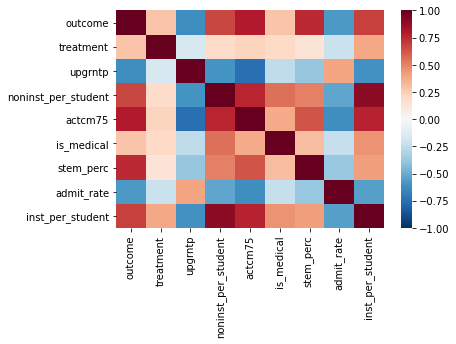

In [520]:
confounders = ['upgrntp','noninst_per_student', 'actcm75', 'is_medical', 'stem_perc', 'admit_rate', 'inst_per_student']
sns.heatmap(df[['outcome', 'treatment'] + confounders].corr(method='spearman'), cmap='RdBu_r', vmin=-1, vmax=1)

In [521]:
df['actcm75'] = df['actcm75'].fillna(df['actcm75'].mean())

In [522]:
REMOVE_COLUMBIA = True
REMOVE_OUTLIERS = True
if REMOVE_COLUMBIA:
    df = df[~df['instnm'].str.contains('Columbia')]
if REMOVE_OUTLIERS:
    df = df[df['Salary Index'] < 100000]

In [523]:
def conditional_densities(data, use_confounders=True):
    formula = "treatment ~ 1"
    if use_confounders:
        formula = ' + '.join([formula] + confounders)
    model = sm.formula.ols(formula, data=data).fit()
    density = stats.norm(
        loc=model.fittedvalues,
        scale=model.resid.std(),
    )
    densities = density.pdf(data["treatment"])
    densities = pd.Series(densities, index=model.fittedvalues.index)
    return densities

data = df
denominator = conditional_densities(data, use_confounders=True)
numerator = conditional_densities(data, use_confounders=False)
generalized_ipw = numerator / denominator
df['weight'] = generalized_ipw

In [524]:
msm = sm.formula.wls(  # Using GEE instead will lead to better (more conservative) uncertainty intervals
    f"outcome ~ 1 + treatment",
    data=data,
    weights=generalized_ipw,
).fit()

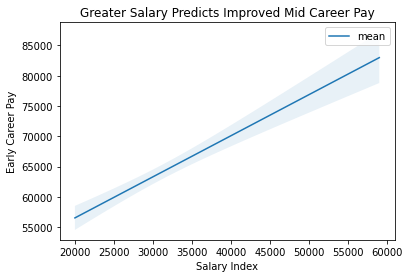

In [525]:
treatment_values = np.arange(20000, 60000, step=1000)
treatment = pd.DataFrame(
    data={"treatment": treatment_values, "I(treatment**2)": treatment_values},
    index=treatment_values,
)
predictions = msm.get_prediction(treatment)
response = predictions.summary_frame(alpha=0.05)
response['x'] = treatment_values
ax = response.plot(
    kind="line",
    x='x',
    y='mean',
    xlabel=TREATMENT_COL,
    ylabel=OUTCOME_COL,
    title='Greater Salary Predicts Improved Mid Career Pay'
)
ax.fill_between(x=response['x'],y1=response['mean_ci_lower'],y2=response['mean_ci_upper'], alpha=.1)

In [526]:
SCHOOL = 'University of California-Berkeley'
row = df[df['instnm'] == SCHOOL].iloc[:1]
msm.predict(row).iloc[0]

60225.41168683253

In [527]:
new_row = row.copy()
new_row['treatment'] += 10000 # increasing GSI pay by $10,000
msm.predict(new_row).iloc[0]

67005.9793754029

<AxesSubplot:xlabel='treatment', ylabel='outcome'>

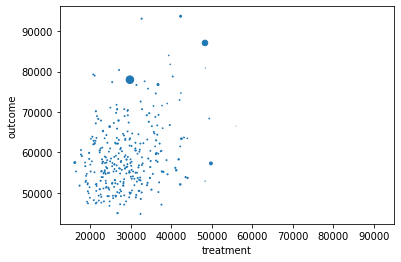

In [528]:
df.plot.scatter(x='treatment',y='outcome',s='weight')

In [529]:
msm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.212
Model:                            WLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     86.05
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           2.71e-18
Time:                        18:20:23   Log-Likelihood:                -3508.1
No. Observations:                 322   AIC:                             7020.
Df Residuals:                     320   BIC:                             7028.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.298e+04   2348.862     18.296      0.000    3.84e+04    4.76e+04
treatment      0.6781      0.073      9.276      0.000       0.534       0.822
==============================================================================
Omnibus:                      314.599   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18682.210
Skew:                           3.786   Prob(JB):                         0.00
Kurtosis:                      39.539   Cond. No.                     1.25e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""